In [1]:
from typing import Optional, Tuple

import numpy as np
from obp.dataset import SyntheticBanditDataset
from obp.utils import sigmoid
from obp.types import BanditFeedback
import pandas as pd

In [2]:
def _get_pokemon_id(x: float) -> int:
    return (x * 10 ** 5).astype(int) % 151 + 1

In [3]:
def _reward_function(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: Optional[int] = None,
) -> np.ndarray:

    pokemon_ids = _get_pokemon_id(context.flatten())
    pokemon_zukan = PokemonZukan()

    capture_probabilities = []
    for pokemon_id in pokemon_ids:
        l = []
        for action in ACTIONS:
            ball_performance = action.performance
            pokemon_capture_dificulty = pokemon_zukan.get_capture_dificulty(pokemon_id)
            capture_probability = sigmoid(ball_performance - pokemon_capture_dificulty)
            l.append(capture_probability)
        capture_probabilities.append(l)
    capture_probabilities = np.array(capture_probabilities)
    return capture_probabilities

In [4]:
def _behavior_policy(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: Optional[int] = None,
) -> np.ndarray:
    pokemon_ids = _get_pokemon_id(context.flatten())
    policy = np.array([rule_based_policy(pokemon_id) for pokemon_id in pokemon_ids])
    return policy

In [5]:
# 現状のSyntheticBanditDatasetは整数値のcontextを生成できないので、暫定的に後処理でcontextを追加する
def _update_context(data: BanditFeedback) -> BanditFeedback:
    pokemon_ids = _get_pokemon_id(data['context'].flatten())
    pokemon_zukan = PokemonZukan()
    rewards = np.array([pokemon_zukan.get_reward(pokemon_id) for pokemon_id in pokemon_ids])
    capture_dificulties = np.array([pokemon_zukan.get_capture_dificulty(pokemon_id) for pokemon_id in pokemon_ids])

    new_context = np.concatenate([pokemon_ids[:, np.newaxis], capture_dificulties[:, np.newaxis], rewards[:, np.newaxis]], axis=1)
    data['context'] = new_context
    return data

In [6]:
# 現状、捕獲したかどうかのrewardになっているので、
# 「捕獲した場合は謝礼金をもらえて、捕獲しなかった場合は何ももらえない」「ボールのコストを差し引く」を考慮したrewardにする
def _update_reward(data: BanditFeedback) -> BanditFeedback:
    rewards = data['context'][:, 2]
    costs = np.array([ACTIONS[action_id].cost for action_id in data['action'].flatten()])
    data['binary_reward'] = data['reward']
    data['reward'] = rewards * data['reward'] - costs
    return data

In [7]:
def _update_expected_reward(data: BanditFeedback) -> BanditFeedback:
    rewards = data['context'][:, 2]
    costs = np.array([action.cost for action in ACTIONS])
    data['expected_reward'] = rewards[:, np.newaxis] * data['expected_reward'] - costs[np.newaxis, :]
    return data

In [8]:
def _post_process(data: BanditFeedback) -> BanditFeedback:
    data = _update_context(data)
    data = _update_reward(data)
    data = _update_expected_reward(data)
    return data

In [9]:
def synthesize_data() -> Tuple[BanditFeedback, BanditFeedback]:
    dataset = SyntheticBanditDataset(
        n_actions=len(ACTIONS),
        dim_context=1,  # pokemon_idの元になるfloat値を生成する
        reward_function=_reward_function,
        behavior_policy_function=_behavior_policy,
        random_state=615,
    )
    training_data = _post_process(dataset.obtain_batch_bandit_feedback(n_rounds=50000))
    validation_data = _post_process(dataset.obtain_batch_bandit_feedback(n_rounds=50000))
    test_data = _post_process(dataset.obtain_batch_bandit_feedback(n_rounds=1000))
    return training_data, validation_data, test_data

In [10]:
from typing import List
from dataclasses import dataclass
import math

In [11]:
@dataclass
class Action:
    label: str
    label_en: str
    performance: int
    cost: int
    color: str
    marker: str

In [12]:
ACTIONS: List[Action] = [
    Action(label='逃げる', label_en='RUN AWAY', performance=-math.inf, cost=0, color='black', marker='o'),
    Action(label='モンスターボールを投げる', label_en='THROW MONSTER-BALL', performance=50, cost=100, color='red', marker='s'),
    Action(label='スーパーボールを投げる', label_en='THROW SUPER-BALL', performance=100, cost=500, color='blue', marker='v'),
    Action(label='ハイパーボールを投げる', label_en='THROW HYPER-BALL', performance=200, cost=2000, color='orange', marker='^'),
    Action(label='マスターボールを投げる', label_en='THROW MASTER-BALL', performance=math.inf, cost=10000, color='violet', marker='x'),
]

In [13]:
# ポケモンの捕獲難度と謝礼金を教えてくれるポケモン図鑑クラス
class PokemonZukan:
    def __init__(self) -> None:
        self._data = pd.read_csv('pokemon.csv', index_col='id')

    def get_capture_dificulty(self, pokemon_id: int) -> int:
        return self._data.loc[pokemon_id]['capture_dificulty']

    def get_reward(self, pokemon_id: int) -> int:
        return self._data.loc[pokemon_id]['reward']

    def get_name(self, pokemon_id: int) -> str:
        return self._data.loc[pokemon_id]['name']

In [14]:
def rule_based_policy(pokemon_id: int) -> Tuple:
    pokemon_zukan = PokemonZukan()

    capture_dificulty = pokemon_zukan.get_capture_dificulty(pokemon_id)
    reward = pokemon_zukan.get_reward(pokemon_id)
    name = pokemon_zukan.get_name(pokemon_id)

    if reward >= 10000:
        return 0.1, 0.1, 0.1, 0.2, 0.5

    if reward >= 2000:
        return 0.05, 0.2, 0.3, 0.4, 0.05

    if reward >= 500:
        return 0.1, 0.3, 0.5, 0.05, 0.05

    if reward >= 100:
        return 0.4, 0.4, 0.1, 0.05, 0.05

    return 0.8, 0.05, 0.05, 0.05, 0.05

In [15]:
training_data, validation_data, test_data = synthesize_data()

In [16]:
training_data

{'n_rounds': 50000,
 'n_actions': 5,
 'context': array([[   46,    65,  1296],
        [   91,   195, 20736],
        [   29,    20,  1191],
        ...,
        [   37,    65,  1502],
        [   68,   210, 12155],
        [   40,   205,  5862]]),
 'action_context': array([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]]),
 'action': array([2, 3, 2, ..., 1, 4, 2]),
 'position': None,
 'reward': array([  796, 18736,   691, ...,  -100,  2155,  -500]),
 'expected_reward': array([[    0.        ,   -99.99960355,   796.        ,  -704.        ,
         -8704.        ],
        [    0.        ,  -100.        ,  -500.        , 18597.21704323,
         10736.        ],
        [    0.        ,  1091.        ,   691.        ,  -809.        ,
         -8809.        ],
        ...,
        [    0.        ,   -99.99954053,  1002.        ,  -498.        ,
         -8498.        ],
        [    0.        ,  -100.        ,  -500.  

In [17]:
validation_data

{'n_rounds': 50000,
 'n_actions': 5,
 'context': array([[  134,   210, 13355],
        [   84,    65,  2234],
        [  111,   135,  3846],
        ...,
        [   98,    30,  3164],
        [   58,    65,  2401],
        [   94,   210, 12744]]),
 'action_context': array([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]]),
 'action': array([4, 1, 3, ..., 3, 2, 0]),
 'position': None,
 'reward': array([3355, -100, 1846, ..., 1164, 1901,    0]),
 'expected_reward': array([[    0.        ,  -100.        ,  -500.        , -1999.39371146,
          3355.        ],
        [    0.        ,   -99.99931661,  1734.        ,   234.        ,
         -7766.        ],
        [    0.        ,  -100.        ,  -500.        ,  1846.        ,
         -6154.        ],
        ...,
        [    0.        ,  3063.99999348,  2664.        ,  1164.        ,
         -6836.        ],
        [    0.        ,   -99.99926553,  1901.        

In [18]:
test_data

{'n_rounds': 1000,
 'n_actions': 5,
 'context': array([[  135,   210, 13355],
        [  118,    30,  2577],
        [   90,    65,  2401],
        ...,
        [   56,    65,  1785],
        [    8,   210,  4358],
        [   13,     0,   366]]),
 'action_context': array([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]]),
 'action': array([4, 2, 3, 3, 0, 3, 4, 3, 4, 3, 1, 1, 4, 4, 2, 3, 1, 3, 2, 3, 3, 4,
        1, 2, 3, 3, 4, 2, 3, 4, 2, 1, 3, 4, 1, 4, 3, 3, 0, 2, 3, 3, 2, 4,
        3, 2, 2, 1, 2, 3, 1, 3, 3, 2, 3, 1, 1, 2, 3, 1, 1, 2, 3, 0, 2, 2,
        2, 4, 3, 2, 3, 2, 3, 2, 0, 4, 2, 2, 2, 1, 3, 2, 2, 4, 3, 2, 3, 3,
        2, 2, 0, 3, 1, 2, 4, 1, 1, 1, 1, 3, 3, 3, 3, 2, 4, 4, 3, 1, 4, 2,
        2, 1, 3, 1, 2, 2, 2, 2, 1, 4, 1, 1, 2, 3, 3, 3, 4, 4, 1, 3, 2, 4,
        2, 2, 2, 1, 1, 3, 3, 1, 3, 0, 2, 0, 3, 4, 1, 4, 0, 4, 2, 1, 1, 2,
        0, 4, 2, 3, 3, 1, 1, 2, 4, 4, 3, 4, 2, 1, 2, 3, 2, 2, 3, 3, 3, 3,
     

In [19]:
from abc import ABCMeta, abstractmethod
from typing import List

from obp.policy import IPWLearner, NNPolicyLearner
from obp.types import BanditFeedback
from obp.ope import DirectMethod, InverseProbabilityWeighting as IPS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [20]:
def deterministic_rule_based_policy(pokemon_id: int) -> Tuple:
    pokemon_zukan = PokemonZukan()

    capture_dificulty = pokemon_zukan.get_capture_dificulty(pokemon_id)
    reward = pokemon_zukan.get_reward(pokemon_id)
    name = pokemon_zukan.get_name(pokemon_id)

    if reward >= 10000:
        return 0, 0, 0, 0, 1

    if reward >= 2000:
        return 0, 0, 0, 1, 0

    if reward >= 500:
        return 0, 0, 1, 0, 0

    if reward >= 100:
        return 0, 1, 0, 0, 0

    return 1, 0, 0, 0, 0

In [21]:
class BaseModel(metaclass=ABCMeta):
    @abstractmethod
    def fit(self, data: BanditFeedback) -> None:
        raise NotImplementedError

    @abstractmethod
    def predict(self, context: np.ndarray) -> List[int]:
        raise NotImplementedError

In [22]:
class IPWModel(BaseModel):
    def __init__(self) -> None:
        self._model = NNPolicyLearner(
            n_actions=len(ACTIONS),
            dim_context=2,
            off_policy_objective=IPS().estimate_policy_value_tensor,
            random_state=615
        )
        self._scaler = StandardScaler()

    def fit(self, data: BanditFeedback) -> None:
        context = data["context"][:, 1:]
        self._scaler.fit(context)
        scaled_context = self._scaler.transform(context)

        self._model.fit(
            context=scaled_context,
            action=data["action"],
            # reward=data["binary_reward"],
            reward=data["reward"],
            pscore=data["pscore"],
        )

    def predict(self, context: np.ndarray) -> np.ndarray:
        scaled_context = self._scaler.transform(context[:, 1:])
        return self._model.predict(context=scaled_context)

In [23]:
class RuleBasedModel(BaseModel):
    def __init__(self) -> None:
        pass

    def fit(self, data: BanditFeedback) -> None:
        # 学習フェーズはない
        pass

    def predict(self, context: np.ndarray) -> np.ndarray:
        pokemon_ids = context[:, 0]
        predictions = []
        for pokemon_id in pokemon_ids:
            probabilities = rule_based_policy(pokemon_id)
            prediction = np.random.multinomial(n=1, pvals=probabilities, size=1)[0]
            predictions.append(prediction)
        return  np.array(predictions)[:, :, np.newaxis]

In [24]:
class DeterministicRuleBasedModel(BaseModel):
    def __init__(self) -> None:
        pass

    def fit(self, data: BanditFeedback) -> None:
        # 学習フェーズはない
        pass

    def predict(self, context: np.ndarray) -> np.ndarray:
        pokemon_ids = context[:, 0]
        predictions = []
        for pokemon_id in pokemon_ids:
            prediction = deterministic_rule_based_policy(pokemon_id)
            predictions.append(np.array(prediction))
        return  np.array(predictions)[:, :, np.newaxis]

In [25]:
models = dict(IPW=IPWModel(), RULE_BASED=DeterministicRuleBasedModel())

In [26]:
action_choices_validation = dict()
action_choices_test = dict()
for model_name, model in models.items():
    print(f'train {model_name}')
    model.fit(data=training_data)

    print(f'predict {model_name}')
    action_choices_validation[model_name] = model.predict(validation_data['context'])
    action_choices_test[model_name] = model.predict(test_data['context'])

train IPW
predict IPW
train RULE_BASED
predict RULE_BASED


In [27]:
from collections import defaultdict
from typing import Dict, List

import matplotlib.pyplot as plt
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DoublyRobust as DR
)
from obp.types import BanditFeedback
from obp.dataset import SyntheticBanditDataset

from pathlib import Path
from sklearn.linear_model import LogisticRegression

In [28]:
def validate(validation_data: BanditFeedback, action_choices: Dict[str, List]) -> None:
    ope = OffPolicyEvaluation(
        bandit_feedback=validation_data, # バリデーションデータ
        ope_estimators=[IPS(estimator_name="IPS")] # 使用する推定量
    )

    ope.visualize_off_policy_estimates_of_multiple_policies(
        policy_name_list=list(action_choices.keys()),
        action_dist_list=list(action_choices.values()),
        random_state=12345,
    )
    plt.show()

    # 可視化
    capture_dificulties = defaultdict(list)
    rewards = defaultdict(list)
    for action, context in zip(action_choices['IPW'], validation_data['context']):
        capture_dificulty = context[1]
        reward = context[2]
        action_id = np.argmax(action)

        capture_dificulties[action_id].append(capture_dificulty)
        rewards[action_id].append(reward)

    fig = plt.figure(figsize = (8, 12))
    ax = fig.add_subplot(111)

    ax.axhline(ACTIONS[4].cost, ls = "-.", color = "magenta")  # マスターボールの価格にラインを引く

    for i, action in enumerate(ACTIONS):
        plt.scatter(capture_dificulties[i], rewards[i], label=action.label_en, c=action.color, marker=action.marker)

    plt.legend(fontsize='xx-large')
    plt.xlabel('Capture difficulty')
    plt.ylabel('Reward')
    plt.show()

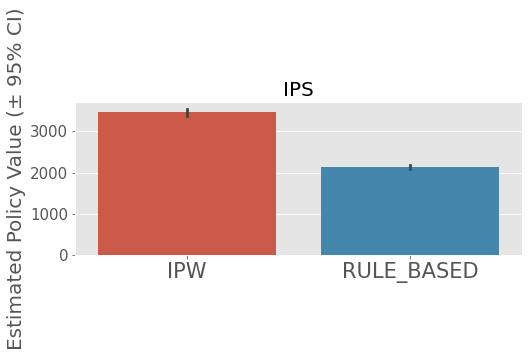

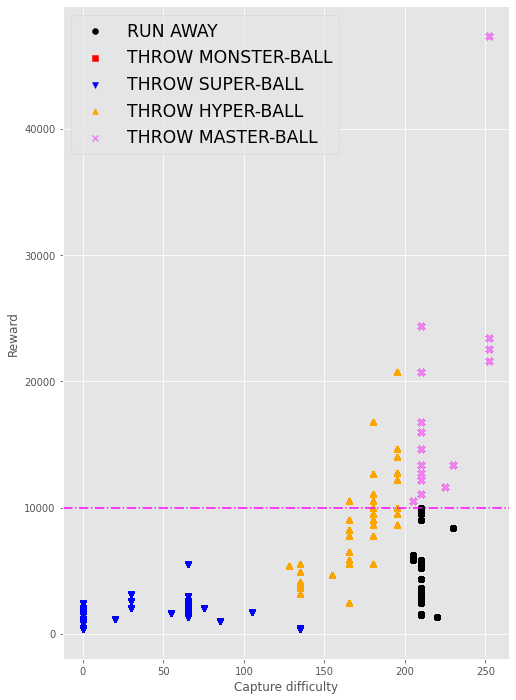

In [29]:
validate(validation_data, action_choices=action_choices_validation)

In [30]:
def evaluate(test_data: BanditFeedback, action_choices: Dict[str, List]) -> None:
    for model_name, action_choice in action_choices.items():
        # 現状calc_ground_truth_policy_valueがSyntheticBanditDatasetのinstance methodになっているので、SyntheticBanditDatasetを適当な初期値でinstance化している。
        ground_truth_score = SyntheticBanditDataset(2).calc_ground_truth_policy_value(expected_reward=test_data['expected_reward'], action_dist=action_choice)
        print(f'{model_name}: {ground_truth_score}')

In [31]:
evaluate(test_data, action_choices=action_choices_test)

IPW: 3202.015954699949
RULE_BASED: 1945.733515775718
